In [525]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
from subprocess import check_output
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

LOWER_BOUND = time.strptime("2018-04-06 00:00:00.000000","%Y-%m-%d %H:%M:%S.%f")
UPPER_BOUND = time.strptime("2018-12-09 00:00:00.000000","%Y-%m-%d %H:%M:%S.%f")
TIMESTAMP_COLUMN = 'dt'

In [526]:
# This function shows the time range of a certain time series
def show_time_range(df, column):
    print("The time range of data frame is from {0} to {1}.".format(df[column].iloc[0], df[column].iloc[-1]))

In [575]:
# This function read csv file from a directory
def read_csv(file_name):
    path_prefix = re.sub(r'predictor/notebook\n', r'datasets', check_output(['pwd']).decode('utf-8'))
    df = pd.read_csv(path_prefix + '/' + file_name)
    # show_time_range(df, 'dt')
    return df

In [559]:
# This function converts string of time stamp in the data frame to time construct
def convert_timestamp(df, column):
    df[column] = df[column].apply(lambda ts: re.search(r'\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}', ts).group(0))
    df[column] = df[column].apply(lambda ts: time.strptime(ts, "%Y-%m-%d %H:%M"))
    df[(df[column] > LOWER_BOUND) & (df[column] < UPPER_BOUND)]

    # Reset index of dataframes
    df = df.reset_index(drop=True)
    
    return df

In [574]:
# This function keeps merging dataframes onto base dataframe
def merge_df(column, df_base, df_dict):
    df_base.rename(columns={'meas':'target'}, inplace=True)
    # print(df_base.head(5))
    for df_name in df_dict:
        df_base = pd.merge(df_base, df_dict[df_name], how='inner', on=['dt'], suffixes=['_1', '_2'])
        # print(df_base.head(5))
    return df_base

In [541]:
context = {}
event = {}
event['variable_files'] = ['pizero_02.csv', 'pizero_02_2.csv', 'pizero_04.csv', 'pizero_05.csv', 'pizero_06.csv']
event['target_file'] = 'pizero_02_dht.csv'

In [581]:
# This is the lambda handler on AWS lambda
def lambda_handler(context, event):
    variable_files = event['variable_files']
    target_file = event['target_file']
    df_dict = {}
    
    df_target = read_csv(target_file)
    df_target = convert_timestamp(df_target, TIMESTAMP_COLUMN)
    
    # Drop the last column of humidity without specifying the column name
    df_target.drop(df_target.columns[len(df_target.columns) - 1], axis=1, inplace=True)

    for file_name in variable_files:
        df_temp = read_csv(file_name)
        name = re.sub('\.csv', '', file_name)
        df_dict[name] = convert_timestamp(df_temp, TIMESTAMP_COLUMN)

    df_join = merge_df('dt', df_target, df_dict)

    # split training data and testing data for X and Y sequentially
    # numpy.split is cumulative
    df_train, df_test = np.split(df_join, [int(0.8*len(df_join))])
    
    # Run univariate regression first
    df_train_X = df_train.iloc[:, 2:]
    df_train_Y = df_train.iloc[:, 1]
    df_test_X = df_test.iloc[:, 2:]
    df_test_Y = df_test.iloc[:, 1]
    
    regr = linear_model.LinearRegression()
    regr.fit(df_train_X, df_train_Y)
    
    df_prediction_Y = regr.predict(df_test_X)
    
    print("==============================================================")
    print("The coefficients of regression model is {0}".format(regr.coef_))
    print("==============================================================")
    print("The intercept of regression model is {0}".format(regr.intercept_))
    print("==============================================================")
    print("The MSE of prediction is {0}".format(mean_squared_error(df_test_Y, df_prediction_Y)))
    print("==============================================================")
    print("The R Square of regression is {0}".format(r2_score(df_test_Y, df_prediction_Y)))
    print("==============================================================")

In [582]:
lambda_handler(context, event)

The coefficients of regression model is [ 0.6061119   0.63357641  0.0669881  -0.00391848 -0.3170916 ]
The intercept of regression model is -32.16085063991892
The MSE of prediction is 10.476078559403526
The R Square of regression is 0.9143572834979432


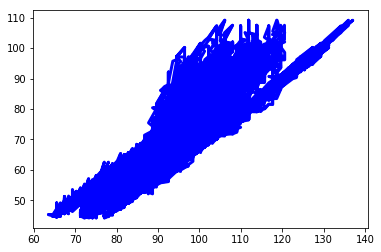

In [524]:
# plt.scatter(df_test_X, df_test_Y, color='green')
plt.plot(df_test_X, df_prediction_Y, color='blue', linewidth=3)
# plt.xticks(())
# plt.yticks(())
plt.show()